# Impacts/pressures
## Case study demonstrator:  Burdekin catchment and influenced coastal areas.
Welcome to the **Living Coasts project**. Here you can find a notebook to search and anlyse the changes (impacts/pressures) occurring within the Burkedin catchment and open coastal environment

#### **Impact**: Water quality change
Change in the physical, chemical and biological characteristics of water and the measure of its condition relative to the requirements for one or more biotic species and/or to any human need or purpose.

#### **Pressure**: Sediment transport (No. 112)
111	Sediment transport - The movement of solid particles (sediment) caused by movement of the water volume.!
(LISTED AS SEDMIMENT TRANSPORT)

#### **Impact (Pressure)**: Increased sediment load (sediment transport)


#### **Evidence for impact** (i.e., water quality change)

Increased turbidity compared to 'normal' conditions.
https://github.com/livingearth-system/Globalchangeframework/blob/main/Evidence-Base-for-Change.md (refers also to increased sediment loads)

#### **Evidence for pressure ** (i.e., sediment transport)
a) Increased average flow velocity (over a month) 
b) Increased amount of water (increase in extent of water within river channel).
c) Increased turbidity
(Seems a bit odd as represents both impact and pressure but reckon this is OK on this occassion).

Other factors might include evidence or erosion or (as below) increased rainfall

Time factors
See: https://github.com/livingearth-system/Globalchangeframework/blob/main/Timefactor.md


### Notes
- Current extent is the Burkedin catchment and the Burkedin River/Upstart Bay/Whitsunday Reefs secondary compartment
- Event is the Dec 2020/Jan 2021 above average rainfall event which led to changes in water quality on the coast
- Data is being pull from eReefs, BOM and DEA
- Time period of impact/pressure is monthly for this demonstration

### Datasets
#### DEA
- Fractional Cover: looking at any increase in the catchment of bare surface
- Land Cover: current issue, only avaliable to 2020
- WoFS: changes in water extent due to any associated flooding
- Turbidity index (need to calc from sentinel-2)

#### eReefs data (only avaliable for open coastal environment)
### Nitrogen
Nitrogen is a key limiting nutrient in the growth of plants and algae. Coral reefs are generally nutrient poor environments with much of the nutrients being locally recycled. Increased nutrient levels promote the growth of phytoplankton, turf algae and macroalgae, inhibiting the rate of recovery of coral reefs.The BGC model tracks the transformation of nitrogen through the nitrogen cycle, from fixing of nitrogen gas into ammonia by tricodesmium, to its uptake by plants, propagation through the food chain to zooplantkon, to release due to mortality and finally denitrification back into nitrogen gas.
 The BGC model contains two forms of dissolved inorganic nitrogen (DIN), dissolved ammonia (NH4) and dissolved nitrate (NO3): DIN = [NH4] + [NO3].

- COD

- BOD

#### BoM
- rainfall
- soil moisture
- river/tidal gauge flow data (not a spatial dataset)






In [1]:
# import packages
import sys
import xarray as xr
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt

sys.path.insert(1, "/home/jovyan/Tools")
import datacube
from dea_tools.spatial import xr_rasterize
from datacube.utils.geometry import Geometry
from dea_tools.datahandling import load_ard
from dea_tools.bandindices import calculate_indices
from dea_tools.plotting import rgb
dc = datacube.Datacube()

In [2]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'


In [3]:
# load in vectors
# catchment
vector_file = '../data/vector_data/drainage_basins/data.gpkg'
attribute_col = 'geometry'

gdf = gpd.read_file(vector_file)
catchment = gdf[gdf['BASIN_NAME'] == 'Burdekin']
catchment = catchment.to_crs("EPSG:3577")

# coastal compartment
vector_file = '../data/vector_data/coastal_compartments/Secondary_compartments.shp'
attribute_col = 'geometry'

gdf = gpd.read_file(vector_file)
compartment = gdf[gdf['Name'] == 'Burdekin River/Upstart Bay/Whitsunday Reefs']
compartment = compartment.to_crs("EPSG:3577")

# intersection of vectors
intersection_gdf = gpd.overlay(catchment, compartment, how='intersection')

# create 'river + nearshore' AOI
riverine_gdf = intersection_gdf.copy()  # Make a copy to keep the original unchanged
riverine_gdf['geometry'] = riverine_gdf['geometry'].buffer(5000)  # Buffer by 5000 meters

In [4]:
riverine_gdf.explore()

In [5]:
# Extract the feature's geometry as a datacube geometry object
geom = Geometry(geom=riverine_gdf.geometry[0], crs=riverine_gdf.crs)

In [6]:
# Create a query object containing parameters used to search for and load our Sentinel-2 data
query = {
    'geopolygon': geom,
    "time": ("2020-11-01", "2021-03-01"),
    "output_crs": "EPSG:3577",
    "resolution": (-100, 100), # change to 10m when happy with outputs
    "group_by": "solar_day",
}

bands = ["nbart_blue", "nbart_green", "nbart_red", "oa_s2cloudless_mask", "oa_s2cloudless_prob"]

ds = load_ard(dc=dc,
                  products=["ga_s2am_ard_3", "ga_s2bm_ard_3"],
                  measurements=bands,              
                  # dask_chunks={'x': 2000, 'y': 2000},
                  # dtype='native',
                  cloud_mask="s2cloudless",
                  mask_pixel_quality=True,
                  min_gooddata=0.30,
                  **query)


# create band index for turbidity ('NDTI2' (Normalised Difference Turbidity Index, Lacaux et al., 2007))
ds_NDTI = calculate_indices(ds, index='NDTI2', collection='ga_s2_3', drop=True)

Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step using s2cloudless


/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Filtering to 23 out of 49 time steps with at least 30.0% good quality pixels
Applying s2cloudless pixel quality/cloud mask
Loading 23 time steps
Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'oa_s2cloudless_mask', 'oa_s2cloudless_prob']


In [7]:
# Generate a polygon mask to keep only data within the polygon
mask = xr_rasterize(riverine_gdf, ds)

# # Mask dataset to set pixels outside the polygon to `NaN`
ds_mask = ds.where(mask)

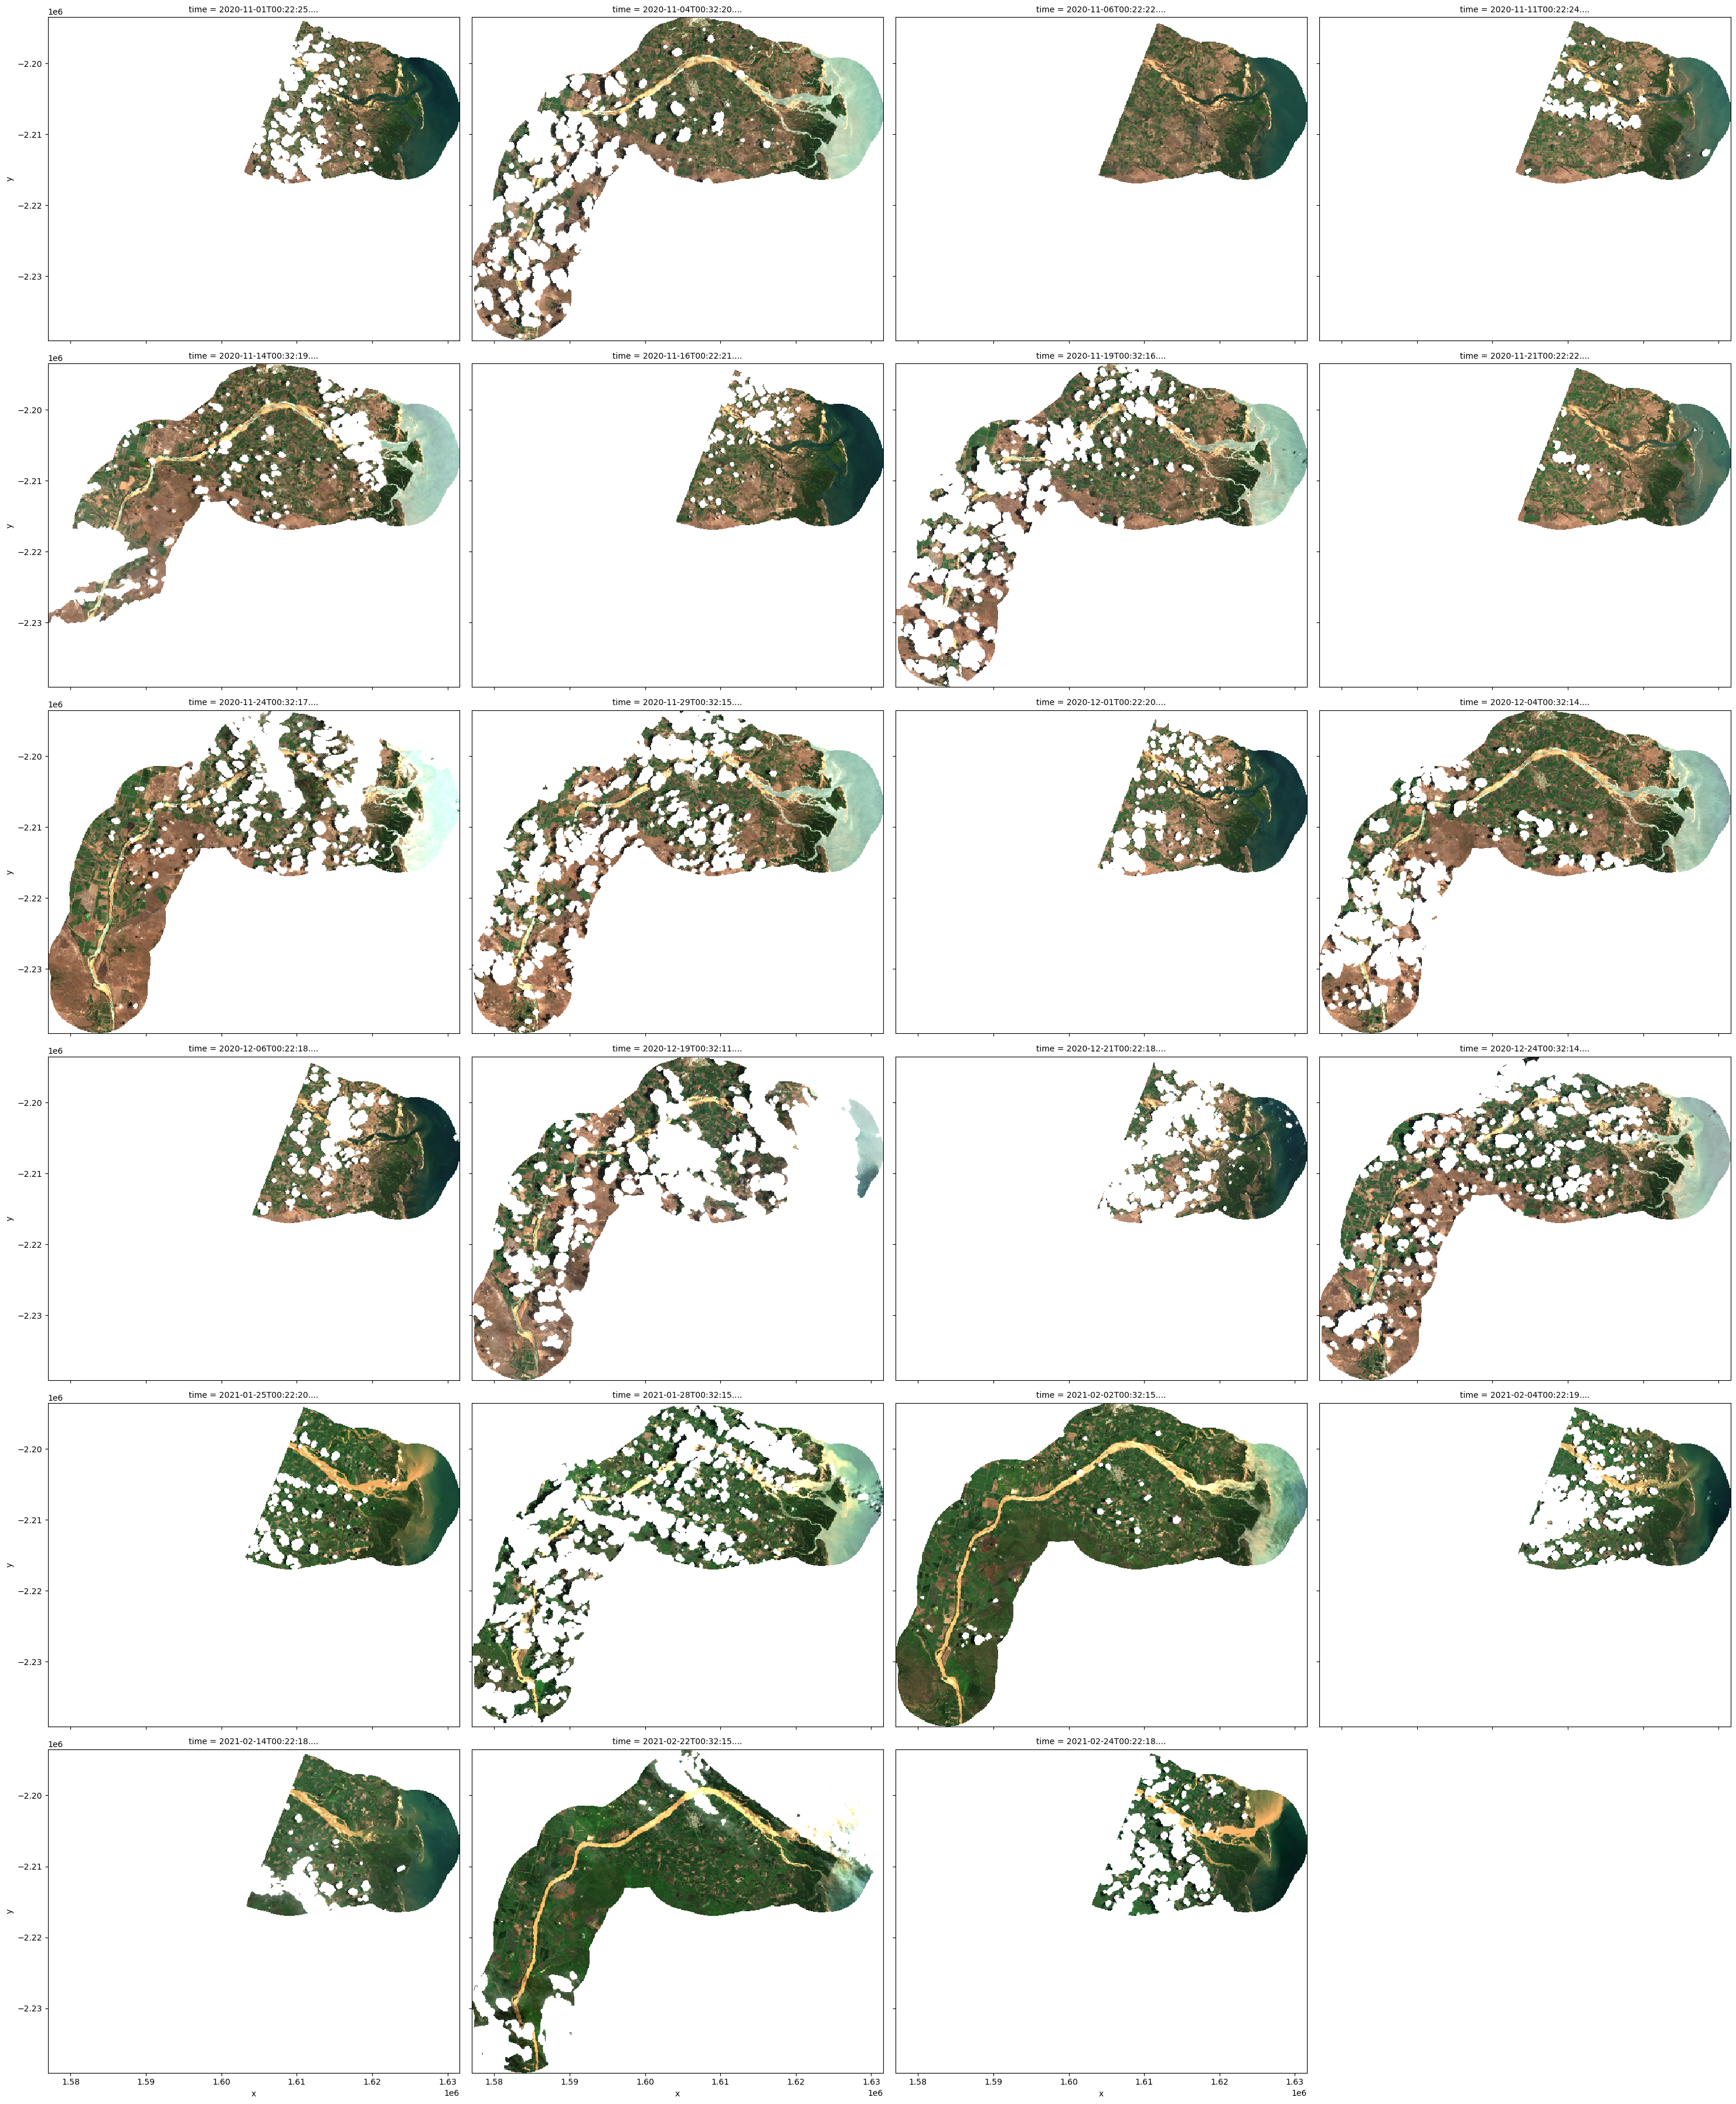

In [8]:
rgb(ds_mask, col='time', vmin=0, vmax=2000)

In [9]:
# Generate a polygon mask to keep only data within the polygon
mask = xr_rasterize(riverine_gdf, ds_NDTI)

# # Mask dataset to set pixels outside the polygon to `NaN`
ds_NDTI_mask = ds_NDTI.where(mask)

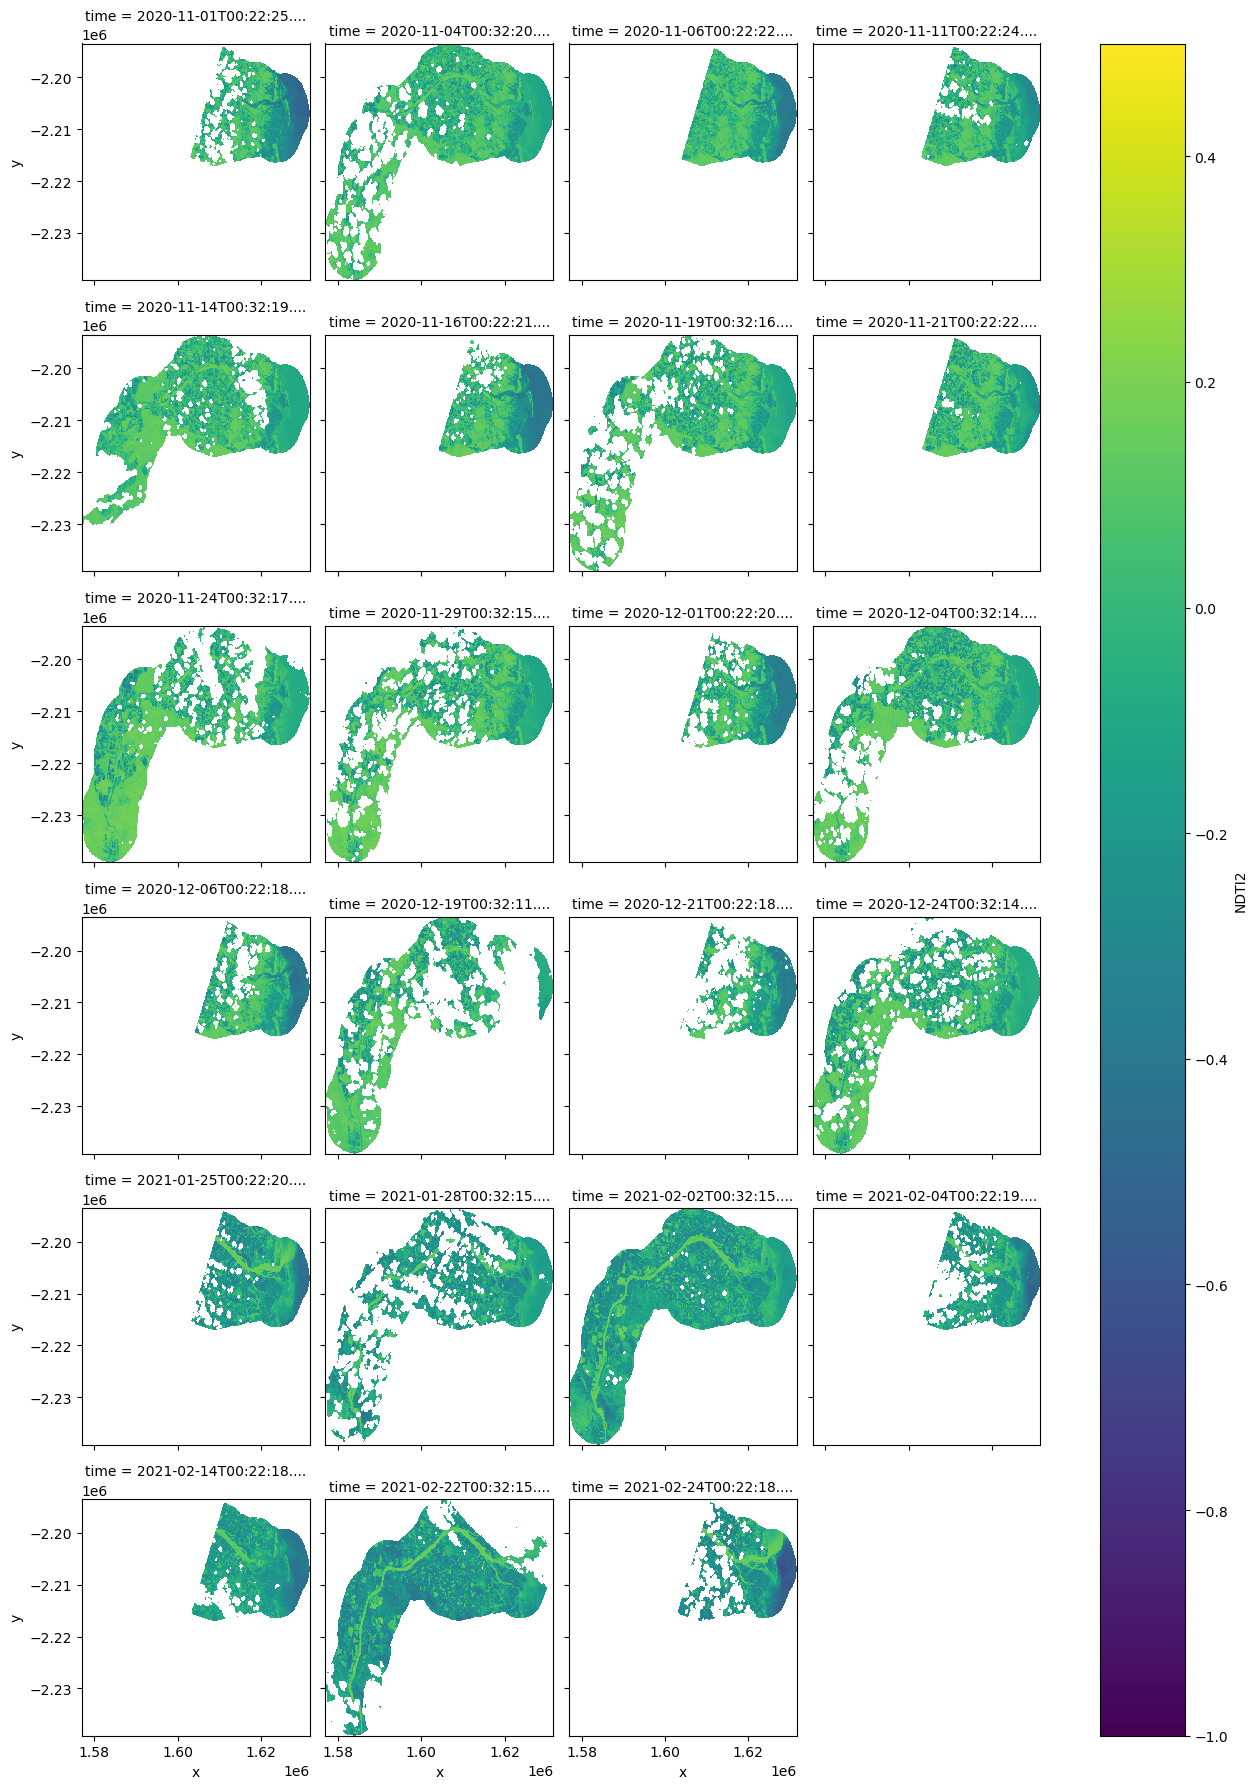

In [10]:
ds_NDTI_mask.NDTI2.plot(col='time', col_wrap=4, vmin=-1, vmax=0.5)

In [11]:
del ds, ds_NDTI_mask, ds_mask

### **Monitoring Water quality using eReefs data** 

To showcase the monitoring system the **BOD, Turbidity, DO and pH** variables have been selected. Any eReefs data can be added using this method.

##### **Loading key variables**

In [12]:
#Linking eReefs data into the notebook
url_eReefs_GBR1_biogeochemistry_sediments = 'https://dapds00.nci.org.au/thredds/dodsC/fx3/GBR1_H2p0_B3p2_Cfur_Dnrt.ncml'
# Opening the data as xarray
dataset_eReefs_GBR1_BGCS = xr.open_dataset(url_eReefs_GBR1_biogeochemistry_sediments)

In [13]:
# Reproject mask to fit the projection system of the eReefs data
mask_4326 = mask.rio.reproject("EPSG:4326")

In [14]:
# Function for loading eReefs variables
def load_eReefs_var(variable, year, mask_4326, depth_index=40):
    dataset = dataset_eReefs_GBR1_BGCS[variable].isel(
                k=depth_index, j=slice(1000,1500),time=dataset_eReefs_GBR1_BGCS.time.dt.year.isin(
                [year])).compute()
    dataset_masked = dataset.where((
                        dataset.longitude > np.round(mask_4326.x.min().values,2)) & (
                        dataset.longitude < np.round(mask_4326.x.max().values,2)) & (
                        dataset.latitude > np.round(mask_4326.y.min().values,2)) & (
                        dataset.latitude < np.round(mask_4326.y.max().values,2)), 
                        drop=True)
    return dataset_masked

##### Loading BOD

In [15]:
burdekin_BOD_2021 = load_eReefs_var("BOD", 2021, mask_4326)

##### Loading Turbidity

In [16]:
burdekin_Turbidity_2021 = load_eReefs_var("Turbidity", 2021, mask_4326)

##### Loading Dissolved Oxygen

In [17]:
burdekin_DO_2021 = load_eReefs_var("Oxygen", 2021, mask_4326)

##### Loading pH

In [18]:
burdekin_pH_2021 = load_eReefs_var("PH", 2021, mask_4326)

##### **Comparing with variable standards**

In [19]:
# Open look-up table containing variable standards 
standards = pd.read_csv('../data/look_up_tables/variable_standards.csv')

In [20]:
standards

Variable  standard_min  standard_max     unit
0        BOD        -99999       6000.00   mg.m-3
1  Turbidity        -99999         30.00      NTU
2         DO          5000      99999.00   mg.m-3
3         pH             7          8.50       pH
4         TN        -99999        300.00   mg.m-3
5         TP        -99999         30.00   mg.m-3
6        Mud        -99999          0.03   kg m-3
7   rain_dec            86         86.00  degreeC
8   rain_jan           138        138.00  degreeC

##### **Plotting**

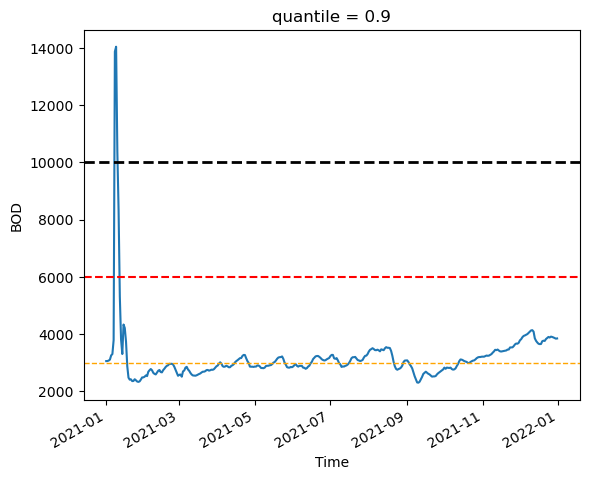

In [21]:
# Create a figure and axis
fig, ax = plt.subplots()

burdekin_BOD_2021.quantile(q=0.9, dim=["j", "i"]).plot()

# Standard treshold
ax.axhline(y=standards[standards.Variable == 'BOD'].standard_max.values[0], color='red', linestyle='--', linewidth=1.5)

# Restricted for Bathing, Contact Water Sports and Commercial Fishing (prescribed by IS:2296 1974)
ax.axhline(y=3000, color='orange', linestyle='--', linewidth=1)
# Very poor quality treshold
ax.axhline(y=10000, color='black', linestyle='--', linewidth=2)

# Display the plot
plt.show()

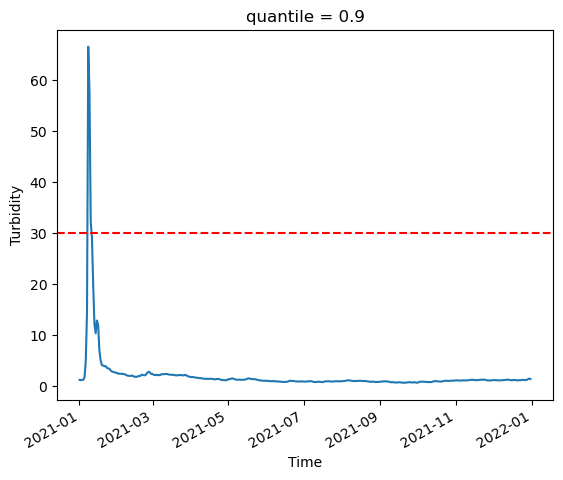

In [22]:
# Create a figure and axis
fig, ax = plt.subplots()

burdekin_Turbidity_2021.quantile(q=0.9, dim=["j", "i"]).plot()

# Standard treshold
ax.axhline(y=standards[standards.Variable == 'Turbidity'].standard_max.values[0], color='red', linestyle='--', linewidth=1.5)

# Display the plot
plt.show()

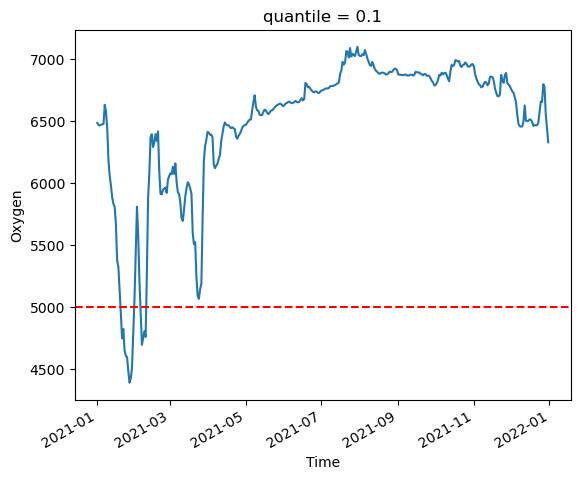

In [23]:
# Create a figure and axis
fig, ax = plt.subplots()

burdekin_DO_2021.quantile(q=0.1, dim=["j", "i"]).plot()

# Standard treshold
ax.axhline(y=standards[standards.Variable == 'DO'].standard_min.values[0], color='red', linestyle='--', linewidth=1.5)

# Display the plot
plt.show()

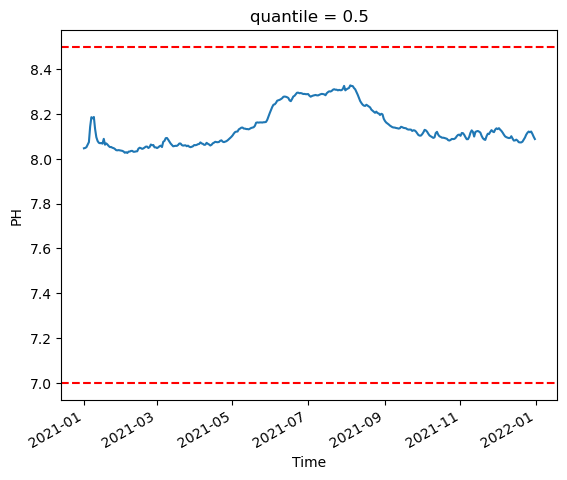

In [24]:
# Create a figure and axis
fig, ax = plt.subplots()

burdekin_pH_2021.quantile(q=0.5, dim=["j", "i"]).plot()

# Standard treshold
ax.axhline(y=standards[standards.Variable == 'pH'].standard_max.values[0], color='red', linestyle='--', linewidth=1.5)

# Standard treshold
ax.axhline(y=standards[standards.Variable == 'pH'].standard_min.values[0], color='red', linestyle='--', linewidth=1.5)

# Display the plot
plt.show()

##### **Raising alert**

In [25]:
# Function that raises quality flag if values are below or above quality standards
def quality_flag(variable, standard):
    poor_quality_dataset = variable.where(
                        (variable.quantile(q=0.9, dim=["j", "i"]) > standard.standard_max.values[0]
                        ) | (
                         variable.quantile(q=0.1, dim=["j", "i"]) < standard.standard_min.values[0]), 
                        drop=True)
    return poor_quality_dataset

In [26]:
poor_quality_BOD_2021 = quality_flag(burdekin_BOD_2021, standards[standards.Variable == 'BOD'])
poor_quality_Turbidity_2021 = quality_flag(burdekin_Turbidity_2021, standards[standards.Variable == 'Turbidity'])
poor_quality_DO_2021 = quality_flag(burdekin_DO_2021, standards[standards.Variable == 'DO'])
poor_quality_pH_2021 = quality_flag(burdekin_pH_2021, standards[standards.Variable == 'pH'])

In [29]:
import datetime
 
# consider the start date as 2021-jan 1st
start_date = datetime.date(2021, 1, 1)
# consider the end date as 2021-jan 31st
end_date = datetime.date(2021, 1, 31)
# delta time
delta = datetime.timedelta(days=1)
 
# iterate over range of dates
while (start_date <= end_date):
    
    if (len(poor_quality_BOD_2021.time)):
        if (str(start_date) in poor_quality_BOD_2021.time.dt.strftime('%Y-%m-%d')):
            print("\n")
            print(color.RED + color.BOLD + "BOD quality flag raised on the ", start_date)
    
    if (len(poor_quality_Turbidity_2021.time)):
        if (str(start_date) in poor_quality_Turbidity_2021.time.dt.strftime('%Y-%m-%d')):
            print(color.RED + color.BOLD + "TURBIDITY quality flag raised on the ", start_date)
    
    if (len(poor_quality_DO_2021.time)):
        if (str(start_date) in poor_quality_DO_2021.time.dt.strftime('%Y-%m-%d')):
            print("\n")
            print(color.RED + color.BOLD + "DO quality flag raised on the ", start_date)
    
    if (len(poor_quality_pH_2021.time)):
        if (str(start_date) in poor_quality_pH_2021.time.dt.strftime('%Y-%m-%d')):
            print(color.RED + color.BOLD + "pH quality flag raised on the ", start_date)
    
    start_date += delta



BOD quality flag raised on the  2021-01-08
TURBIDITY quality flag raised on the  2021-01-08


BOD quality flag raised on the  2021-01-09
TURBIDITY quality flag raised on the  2021-01-09


BOD quality flag raised on the  2021-01-10
TURBIDITY quality flag raised on the  2021-01-10


BOD quality flag raised on the  2021-01-11


DO quality flag raised on the  2021-01-20


DO quality flag raised on the  2021-01-21


DO quality flag raised on the  2021-01-22


DO quality flag raised on the  2021-01-23


DO quality flag raised on the  2021-01-24


DO quality flag raised on the  2021-01-25


DO quality flag raised on the  2021-01-26


DO quality flag raised on the  2021-01-27


DO quality flag raised on the  2021-01-28


DO quality flag raised on the  2021-01-29


DO quality flag raised on the  2021-01-30


### **Monitoring potential Pressures using eReefs data** 

Quality flag was raised for BOD Turbidity, indicating that the water quality changed in the study areas. Potential pressures for water quality change include nutrification and sediment transport, which can affect the water quality within month range.

##### Loading Total Nitrogen 

In [30]:
burdekin_TN_2020 = load_eReefs_var("TN", 2020, mask_4326)
burdekin_TN_2021 = load_eReefs_var("TN", 2021, mask_4326)
burdekin_TN_pressure_timeframe = xr.concat(
          [burdekin_TN_2020.sel(time=slice('2020-12-01', '2020-12-31')), 
           burdekin_TN_2021.sel(time=slice('2021-01-01', '2021-01-11'))], 
                            dim="time")

del burdekin_TN_2020, burdekin_TN_2021

##### Loading Total Phosphorus 

In [31]:
burdekin_TP_2020 = load_eReefs_var("TP", 2020, mask_4326)
burdekin_TP_2021 = load_eReefs_var("TP", 2021, mask_4326)
burdekin_TP_pressure_timeframe = xr.concat(
          [burdekin_TP_2020.sel(time=slice('2020-12-01', '2020-12-31')), 
           burdekin_TP_2021.sel(time=slice('2021-01-01', '2021-01-11'))], 
                            dim="time")

del burdekin_TP_2020, burdekin_TP_2021

##### Loading TSS

In [32]:
### Would be good to have TSS but not working from eReefs. Other source?

##### Loading Mud-mineral

In [33]:
burdekin_Mud_2020 = load_eReefs_var("Mud-mineral", 2020, mask_4326)
burdekin_Mud_2021 = load_eReefs_var("Mud-mineral", 2021, mask_4326)
burdekin_Mud_pressure_timeframe = xr.concat(
          [burdekin_Mud_2020.sel(time=slice('2020-12-01', '2020-12-31')), 
           burdekin_Mud_2021.sel(time=slice('2021-01-01', '2021-01-11'))], 
                            dim="time")

del burdekin_Mud_2020, burdekin_Mud_2021

##### Loading Sand-mineral

In [34]:
burdekin_Sand_2020 = load_eReefs_var("Sand-mineral", 2020, mask_4326)
burdekin_Sand_2021 = load_eReefs_var("Sand-mineral", 2021, mask_4326)
burdekin_Sand_pressure_timeframe = xr.concat(
          [burdekin_Sand_2020.sel(time=slice('2020-12-01', '2020-12-31')), 
           burdekin_Sand_2021.sel(time=slice('2021-01-01', '2021-01-11'))], 
                            dim="time")

del burdekin_Sand_2020, burdekin_Sand_2021

##### Loading Gravel-mineral

In [35]:
burdekin_Gravel_2020 = load_eReefs_var("Gravel-mineral", 2020, mask_4326)
burdekin_Gravel_2021 = load_eReefs_var("Gravel-mineral", 2021, mask_4326)
burdekin_Gravel_pressure_timeframe = xr.concat(
          [burdekin_Gravel_2020.sel(time=slice('2020-12-01', '2020-12-31')), 
           burdekin_Gravel_2021.sel(time=slice('2021-01-01', '2021-01-11'))], 
                            dim="time")

del burdekin_Gravel_2020, burdekin_Gravel_2021

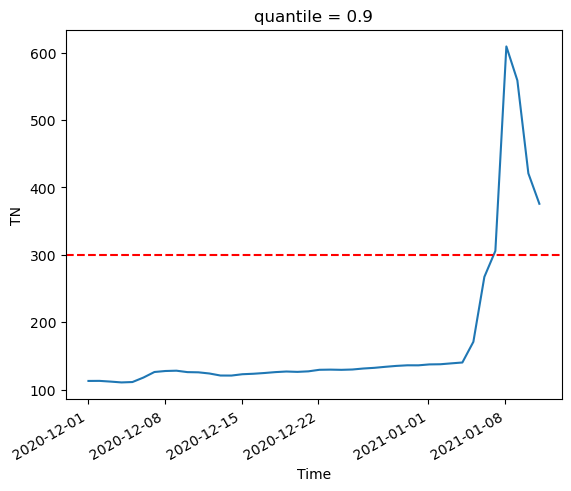

In [36]:
# Create a figure and axis
fig, ax = plt.subplots()

burdekin_TN_pressure_timeframe.quantile(q=0.9, dim=["j", "i"]).plot()

# Standard treshold
ax.axhline(y=standards[standards.Variable == 'TN'].standard_max.values[0], color='red', linestyle='--', linewidth=1.5)

# Display the plot
plt.show()

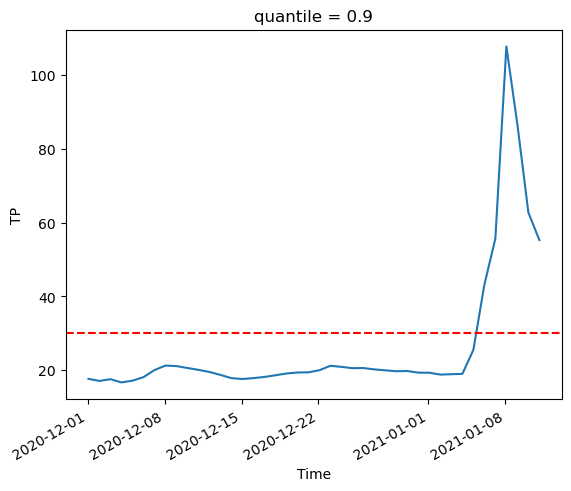

In [37]:
# Create a figure and axis
fig, ax = plt.subplots()

burdekin_TP_pressure_timeframe.quantile(q=0.9, dim=["j", "i"]).plot()

# Standard treshold
ax.axhline(y=standards[standards.Variable == 'TP'].standard_max.values[0], color='red', linestyle='--', linewidth=1.5)

# Display the plot
plt.show()

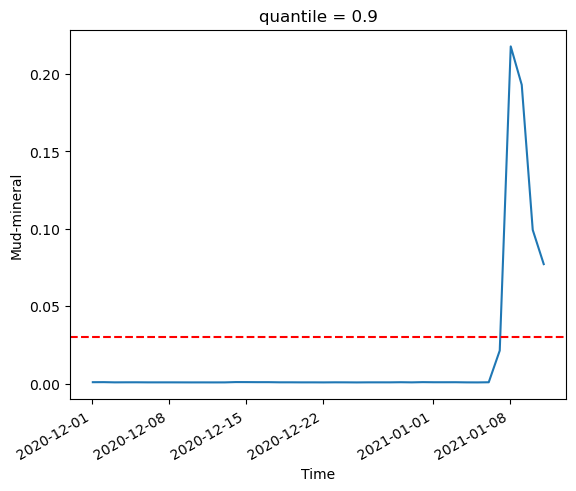

In [38]:
# Create a figure and axis
fig, ax = plt.subplots()

burdekin_Mud_pressure_timeframe.quantile(q=0.9, dim=["j", "i"]).plot()

# Standard treshold
ax.axhline(y=0.03, color='red', linestyle='--', linewidth=1.5)

# Display the plot
plt.show()

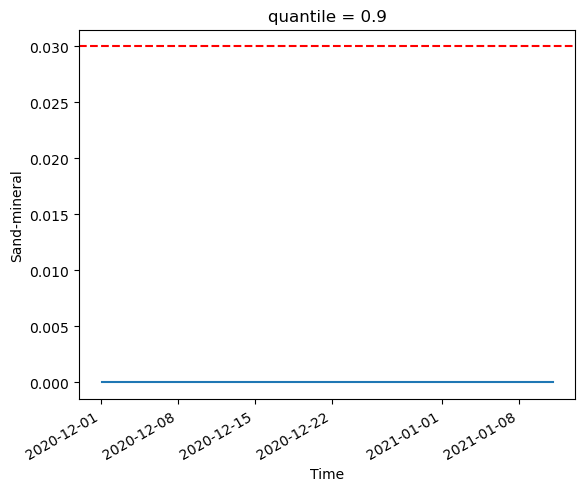

In [39]:
# Create a figure and axis
fig, ax = plt.subplots()

burdekin_Sand_pressure_timeframe.quantile(q=0.9, dim=["j", "i"]).plot()

# Standard treshold
ax.axhline(y=0.03, color='red', linestyle='--', linewidth=1.5)

# Display the plot
plt.show()

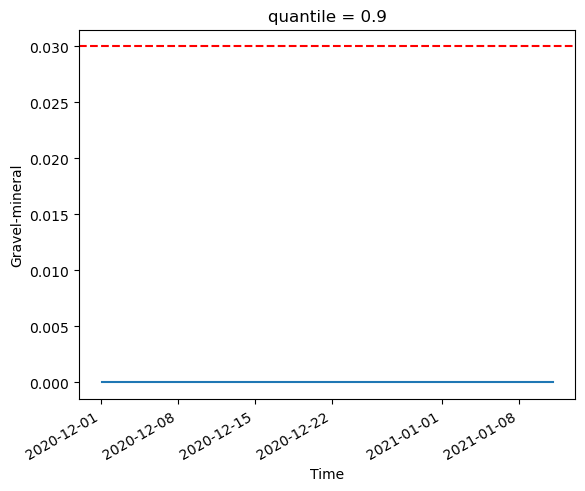

In [40]:
# Create a figure and axis
fig, ax = plt.subplots()

burdekin_Gravel_pressure_timeframe.quantile(q=0.9, dim=["j", "i"]).plot()

# Standard treshold
ax.axhline(y=0.03, color='red', linestyle='--', linewidth=1.5)

# Display the plot
plt.show()

In [43]:
# consider the start date as 2021-jan 1st
start_date = datetime.date(2020, 12, 1)
# consider the end date as 2021-jan 31st
end_date = datetime.date(2021, 1, 11)
# delta time
delta = datetime.timedelta(days=1)
 
# iterate over range of dates
while (start_date <= end_date):
    
    if (len(burdekin_TN_pressure_timeframe.time)):
        if (str(start_date) in burdekin_TN_pressure_timeframe.time.dt.strftime('%Y-%m-%d')):
            print("\n")
            print("Total N quality flag raised on the ", start_date)
    
    if (len(burdekin_TP_pressure_timeframe.time)):
        if (str(start_date) in burdekin_TP_pressure_timeframe.time.dt.strftime('%Y-%m-%d')):
            print("Total P quality flag raised on the ", start_date)
    
    if (len(burdekin_Mud_pressure_timeframe.time)):
        if (str(start_date) in burdekin_Mud_pressure_timeframe.time.dt.strftime('%Y-%m-%d')):
            print("DO quality flag raised on the ", start_date)
    
    start_date += delta



Total N quality flag raised on the  2020-12-01
Total P quality flag raised on the  2020-12-01
DO quality flag raised on the  2020-12-01


Total N quality flag raised on the  2020-12-02
Total P quality flag raised on the  2020-12-02
DO quality flag raised on the  2020-12-02


Total N quality flag raised on the  2020-12-03
Total P quality flag raised on the  2020-12-03
DO quality flag raised on the  2020-12-03


Total N quality flag raised on the  2020-12-04
Total P quality flag raised on the  2020-12-04
DO quality flag raised on the  2020-12-04


Total N quality flag raised on the  2020-12-05
Total P quality flag raised on the  2020-12-05
DO quality flag raised on the  2020-12-05


Total N quality flag raised on the  2020-12-06
Total P quality flag raised on the  2020-12-06
DO quality flag raised on the  2020-12-06


Total N quality flag raised on the  2020-12-07
Total P quality flag raised on the  2020-12-07
DO quality flag raised on the  2020-12-07


Total N quality flag raised on t

### **Monitoring potential Pressures using BOM data** 

In [44]:
# Problem of spatial lag in addition to temporal lag!!!

In [45]:
def load_rain_monthly(month, year, mask_4326):
    url_NCI_rain_monthly = 'https://dapds00.nci.org.au/thredds/dodsC/gh70/ANUClimate/v2-0/stable/month/rain/'+year+'/ANUClimate_v2-0_rain_monthly_'+year+month+'.nc'
    dataset_NCI_rain_monthly = xr.open_dataset(url_NCI_rain_monthly)
    dataset_masked = dataset_NCI_rain_monthly.where((
                        dataset_NCI_rain_monthly.lon > np.round(mask_4326.x.min().values,2)) & (
                        dataset_NCI_rain_monthly.lon < np.round(mask_4326.x.max().values,2)) & (
                        dataset_NCI_rain_monthly.lat > np.round(mask_4326.y.min().values,2)) & (
                        dataset_NCI_rain_monthly.lat < np.round(mask_4326.y.max().values,2)), 
                        drop=True)

    
    return dataset_masked

In [46]:
# Get BOM data for the potential pressure timeframe
dataset_NCI_rain_202012 = load_rain_monthly('12', '2020', mask_4326)
dataset_NCI_rain_202101 = load_rain_monthly('01', '2021', mask_4326)

In [47]:
# Function that raises flag if values are below or above climatic normals
def excess_prec_flag(variable, standard):
    rain_med = variable.median(dim=["lat", "lon"]).values[0] 
    if (rain_med > standard.standard_max.values[0]):
        excess_precipitation = True
    else: 
        excess_precipitation = False
    return excess_precipitation

In [48]:
# Check monthly precipitation pressure
excess_prec_202012 = excess_prec_flag(
                        dataset_NCI_rain_202012.rain, standards[standards.Variable == 'rain_dec'])
excess_prec_202101 = excess_prec_flag(
                        dataset_NCI_rain_202101.rain, standards[standards.Variable == 'rain_jan'])


# Write warning message 
if excess_prec_202012==True:
    print(color.RED + color.BOLD + "Excess precipitation during December 2020" + color.END)
if excess_prec_202101==True:
    print(color.RED + color.BOLD + "Excess precipitation during January 2021" + color.END)


Excess precipitation during December 2020
Excess precipitation during January 2021
